In [1]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submit = pd.read_csv('dataset/submit.csv')

test_df = pd.merge(test, submit, on='id', how='left')

In [4]:
train

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [5]:
# Filling NaN values in specific columns
train['title'].fillna('Untitled', inplace=True)
train['author'].fillna('unknown', inplace=True)

# Dropping rows with NaN values in the 'text' column
train.dropna(subset=['text'], inplace=True)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20761 non-null  object
 2   author  20761 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB


In [7]:
train.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,unknown,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,unknown,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [8]:
train['combined'] = train['title'].astype(str) + ' ' + train['author'].astype(str) + ' ' + train['text'].astype(str)
train['combined']

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2        Why the Truth Might Get You Fired Consortiumne...
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
                               ...                        
20795    Rapper T.I.: Trump a ’Poster Child For White S...
20796    N.F.L. Playoffs: Schedule, Matchups and Odds -...
20797    Macy’s Is Said to Receive Takeover Approach by...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799    What Keeps the F-35 Alive David Swanson   Davi...
Name: combined, Length: 20761, dtype: object

In [9]:
tdf = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_df=0.85, min_df=0.01 )


In [10]:
X = tdf.fit_transform(train['combined'])
y = train['label']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [13]:
# Creating DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters for classification
params = {
    'objective': 'multi:softmax',  # for multi-class classification
    'num_class': 3,  # number of classes in the target variable
    'eval_metric': 'mlogloss',  # metric for evaluation
    'eta': 0.3,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Training the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Making predictions on the test set
y_pred = model.predict(dtest)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


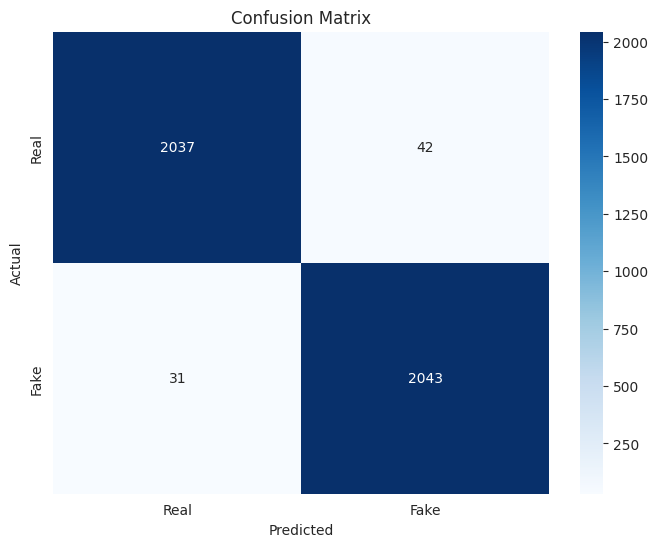

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Making predictions on the test set
y_pred = model.predict(dtest)

# Convert predicted probabilities to class labels
y_pred_labels = [int(round(pred)) for pred in y_pred]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
def news_to_vector(news_dict):
    x = str(news_dict['title']) + ' ' + str(news_dict['author']) + ' ' + str(news_dict['text'])
    return tdf.transform([x])  # Use transform instead of fit_transform


In [16]:
dnew = xgb.DMatrix(news_to_vector(test_df.loc[1]))

a = model.predict(dnew)

In [18]:
a

array([1.], dtype=float32)

In [17]:
if a == 1: print('ok')

ok


In [59]:
test_df.loc[1]

id                                                    20801
title     Russian warships ready to strike terrorists ne...
author                                                  NaN
text      Russian warships ready to strike terrorists ne...
label                                                     1
Name: 1, dtype: object